In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
#TF-IDF + Basic Algoritms
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
from sklearn.model_selection import GridSearchCV
#WE + NN
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer



from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# dir = r'D:/TechProjects/fake-rr-detection/fake reviews dataset.csv'
dir =r'/content/fake reviews dataset.csv'

In [3]:
df = pd.read_csv(dir)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18211 entries, 0 to 18210
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   category  18211 non-null  object 
 1   rating    18211 non-null  float64
 2   label     18211 non-null  object 
 3   text_     18211 non-null  object 
dtypes: float64(1), object(3)
memory usage: 569.2+ KB


In [ ]:
df.columns

Index(['category', 'rating', 'label', 'text_'], dtype='object')

In [ ]:
for col in ['category', 'rating', 'label']:
  print('\n',
        df[col].value_counts(),
        '\n')


 category
Kindle_Store_5                  4730
Books_5                         4370
Pet_Supplies_5                  4254
Home_and_Kitchen_5              4056
Electronics_5                   3988
Sports_and_Outdoors_5           3946
Tools_and_Home_Improvement_5    3858
Clothing_Shoes_and_Jewelry_5    3848
Toys_and_Games_5                3794
Movies_and_TV_5                 3588
Name: count, dtype: int64 


 rating
5.0    24559
4.0     7965
3.0     3786
1.0     2155
2.0     1967
Name: count, dtype: int64 


 label
CG    20216
OR    20216
Name: count, dtype: int64 



# TF-IDF + LR, RF, GB

In [20]:
df['label'] = df['label'].map({'OR': 0, 'CG': 1})

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df['text_'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)

In [ ]:
# TF-IDF vectorization object
tfidf = TfidfVectorizer(max_features=5000, stop_words="english", ngram_range=(1,2))

# tranformation
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [ ]:
print(f"train size - {X_train_tfidf.shape}")
print(f"test size - {X_test_tfidf.shape}")

train size - (32345, 5000)
test size - (8087, 5000)


## Models

#### LOG REG

In [ ]:
#Logistic regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_tfidf, y_train)

y_pred_lr = lr.predict(X_test_tfidf)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

Logistic Regression Accuracy: 0.8841350315320885
              precision    recall  f1-score   support

           0       0.88      0.89      0.89      4044
           1       0.89      0.88      0.88      4043

    accuracy                           0.88      8087
   macro avg       0.88      0.88      0.88      8087
weighted avg       0.88      0.88      0.88      8087



In [ ]:
param_grid_lr = {
    'C': [0.01, 0.1, 1, 3, 4, 5, 8, 10],  # Регуляризация
    'solver': ['liblinear', 'lbfgs']
}

grid_lr = GridSearchCV(LogisticRegression(max_iter=500), param_grid_lr, cv=3, scoring='accuracy', n_jobs=-1)
grid_lr.fit(X_train_tfidf, y_train)

print("Best Logistic Regression Params:", grid_lr.best_params_)
y_pred_lr = grid_lr.best_estimator_.predict(X_test_tfidf)
print("Logistic Regression Accuracy after GridSearch:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

Best Logistic Regression Params: {'C': 5, 'solver': 'liblinear'}
Logistic Regression Accuracy after GridSearch: 0.8864844812662298
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      4044
           1       0.89      0.89      0.89      4043

    accuracy                           0.89      8087
   macro avg       0.89      0.89      0.89      8087
weighted avg       0.89      0.89      0.89      8087



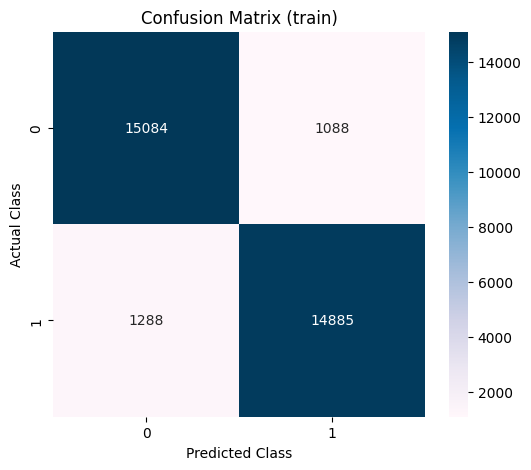

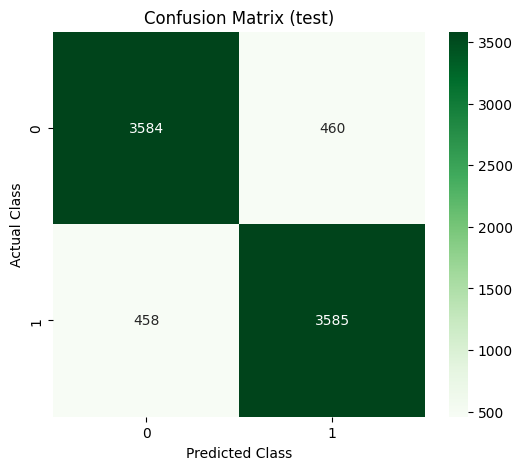

AUC-ROC на тренировочном наборе: 0.9806
AUC-ROC на тестовом наборе: 0.9588


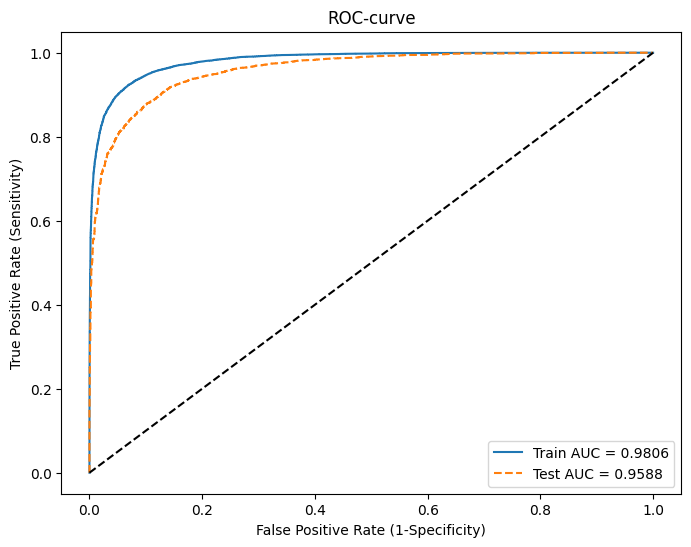

In [ ]:
# calculating probabilities AUC-ROC
y_train_pred_prob = grid_lr.best_estimator_.predict_proba(X_train_tfidf)[:, 1]
y_test_pred_prob = grid_lr.best_estimator_.predict_proba(X_test_tfidf)[:, 1]

#confusion matrix for train
conf_matrix_train = confusion_matrix(y_train, grid_lr.best_estimator_.predict(X_train_tfidf))
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_train, annot=True, fmt="d", cmap="PuBu")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.title("Confusion Matrix (train)")
plt.show()

# confusion matrix for test
conf_matrix_test = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="Greens")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.title("Confusion Matrix (test)")
plt.show()

# AUC-ROC
roc_auc_train = roc_auc_score(y_train, y_train_pred_prob)
roc_auc_test = roc_auc_score(y_test, y_test_pred_prob)

print(f"AUC-ROC на тренировочном наборе: {roc_auc_train:.4f}")
print(f"AUC-ROC на тестовом наборе: {roc_auc_test:.4f}")

# ROC CURVE
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_prob)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label=f"Train AUC = {roc_auc_train:.4f}")
plt.plot(fpr_test, tpr_test, label=f"Test AUC = {roc_auc_test:.4f}", linestyle="--")
plt.plot([0, 1], [0, 1], "k--")  # diagonal line of random classifier
plt.xlabel("False Positive Rate (1-Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.title("ROC-curve")
plt.legend()
plt.show()

 #### RANDOM FOREST

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_tfidf, y_train)

y_pred_rf = rf.predict(X_test_tfidf)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 0.8450599727958452
              precision    recall  f1-score   support

           0       0.85      0.84      0.84      4044
           1       0.84      0.85      0.85      4043

    accuracy                           0.85      8087
   macro avg       0.85      0.85      0.85      8087
weighted avg       0.85      0.85      0.85      8087



In [ ]:
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [ None],       # больше глубины, None
    'min_samples_split': [ 2, 5, 10],       # чуть агрессивнее 2,
    'min_samples_leaf': [5, 7],        # мягче ограничение
}

grid_rf = GridSearchCV(
    RandomForestClassifier(
        random_state=42,
        max_features='sqrt',           # вернули sqrt — более сбалансированно    0.3,#
        max_samples=0.6,               # чуть больше примеров на дерево
        oob_score=True,
        n_jobs=-1
    ),
    param_grid_rf,
    cv=3,
    scoring='accuracy',                 # можно также f1/accuracy
    n_jobs=-1
)

grid_rf.fit(X_train_tfidf, y_train)

# Оценка
best_rf = grid_rf.best_estimator_
y_train_proba = best_rf.predict_proba(X_train_tfidf)[:, 1]
y_test_proba = best_rf.predict_proba(X_test_tfidf)[:, 1]
y_pred = best_rf.predict(X_test_tfidf)

print("Best Random Forest Params:", grid_rf.best_params_)
print(f"OOB Score: {best_rf.oob_score_:.4f}")
print(f"AUC-ROC на тренировочном наборе: {roc_auc_score(y_train, y_train_proba):.4f}")
print(f"AUC-ROC на тестовом наборе: {roc_auc_score(y_test, y_test_proba):.4f}")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Best Random Forest Params: {'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 200}
OOB Score: 0.8276
AUC-ROC на тренировочном наборе: 0.9537
AUC-ROC на тестовом наборе: 0.9197
Accuracy: 0.8401137628292321
              precision    recall  f1-score   support

           0       0.83      0.86      0.84      4044
           1       0.86      0.82      0.84      4043

    accuracy                           0.84      8087
   macro avg       0.84      0.84      0.84      8087
weighted avg       0.84      0.84      0.84      8087



In [ ]:
#Separately the best classifier
rf = RandomForestClassifier(n_estimators=200, random_state=42, max_depth=None, min_samples_leaf=10, min_samples_split=20)
rf.fit(X_train_tfidf, y_train)

y_pred_rf = rf.predict(X_test_tfidf)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 0.8214418202052677
              precision    recall  f1-score   support

           0       0.84      0.80      0.82      4044
           1       0.81      0.85      0.83      4043

    accuracy                           0.82      8087
   macro avg       0.82      0.82      0.82      8087
weighted avg       0.82      0.82      0.82      8087



In [ ]:
grid_rf

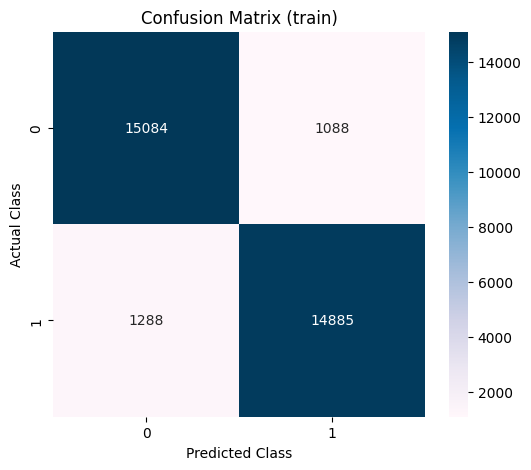

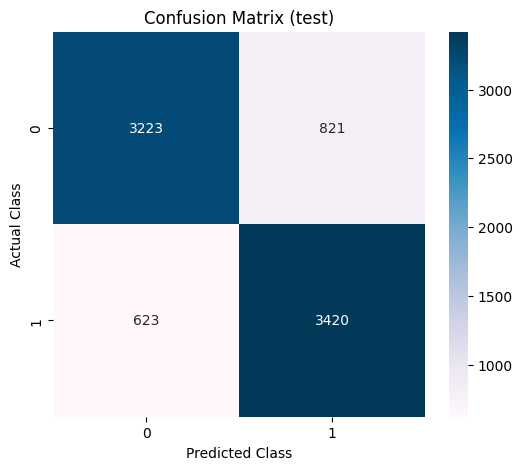

AUC-ROC на тренировочном наборе: 0.9537
AUC-ROC на тестовом наборе: 0.9197


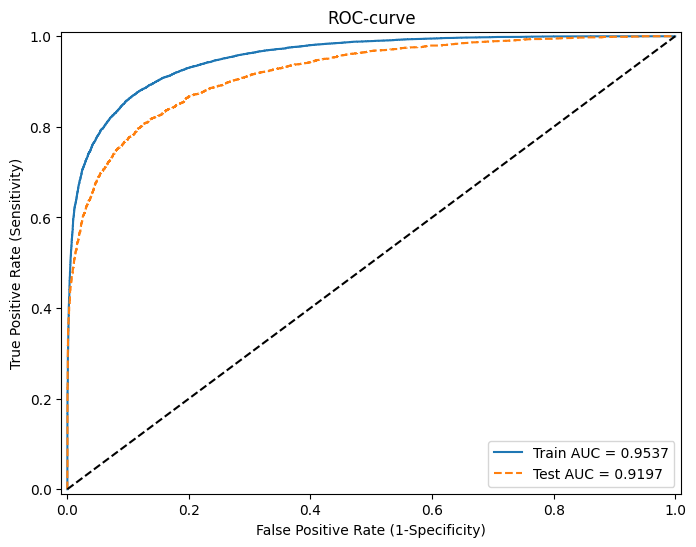

In [ ]:
# calculating probabilities AUC-ROC
y_train_pred_prob = grid_rf.best_estimator_.predict_proba(X_train_tfidf)[:, 1]
y_test_pred_prob = grid_rf.best_estimator_.predict_proba(X_test_tfidf)[:, 1]
# y_train_pred_prob = rf.predict_proba(X_train_tfidf)[:, 1]
# y_test_pred_prob = rf.predict_proba(X_test_tfidf)[:, 1]

#confusion matrix for train
conf_matrix_train = confusion_matrix(y_train, grid_lr.best_estimator_.predict(X_train_tfidf))
# conf_matrix_train = confusion_matrix(y_train, rf.predict(X_train_tfidf))
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_train, annot=True, fmt="d", cmap="PuBu")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.title("Confusion Matrix (train)")
plt.show()

# confusion matrix for test
conf_matrix_test = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="PuBu")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.title("Confusion Matrix (test)")
plt.show()

# AUC-ROC
roc_auc_train = roc_auc_score(y_train, y_train_pred_prob)
roc_auc_test = roc_auc_score(y_test, y_test_pred_prob)

print(f"AUC-ROC на тренировочном наборе: {roc_auc_train:.4f}")
print(f"AUC-ROC на тестовом наборе: {roc_auc_test:.4f}")

# ROC CURVE
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_prob)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label=f"Train AUC = {roc_auc_train:.4f}")
plt.plot(fpr_test, tpr_test, label=f"Test AUC = {roc_auc_test:.4f}", linestyle="--")
plt.plot([0, 1], [0, 1], "k--")  # diagonal line of random classifier
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel("False Positive Rate (1-Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.title("ROC-curve")
plt.legend()
plt.show()

GRADIENT BOOSTING

In [ ]:
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gb.fit(X_train_tfidf, y_train)

y_pred_gb = gb.predict(X_test_tfidf)
print("Gradient Boosting Accuracy:", accuracy_score(y_test, y_pred_gb))
print(classification_report(y_test, y_pred_gb))

In [ ]:
param_grid_gb = {
    'n_estimators': [50, 100, 200],  # Количество деревьев
    'learning_rate': [0.01, 0.1, 0.2],  # Скорость обучения
    'max_depth': [None],  # Глубина деревьев
}

grid_gb = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid_gb, cv=3, scoring='accuracy', n_jobs=-1)
grid_gb.fit(X_train_tfidf, y_train)

print("Best Gradient Boosting Params:", grid_gb.best_params_)
y_pred_gb = grid_gb.best_estimator_.predict(X_test_tfidf)
print("Gradient Boosting Accuracy after GridSearch:", accuracy_score(y_test, y_pred_gb))
print(classification_report(y_test, y_pred_gb))

# WE + NN

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [19]:
df.head()

,category,rating,label,text_
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor..."
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I..."
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i..."
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...


In [21]:
texts = df['text_'].astype(str).values  # отзывы
labels = df['label'].values

In [22]:
# Гиперпараметры
MAX_VOCAB_SIZE = 10000   # Размер словаря
MAX_SEQUENCE_LENGTH = 200 # Максимальная длина отзыва

# Создаём токенайзер
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)

# Преобразуем текст в последовательности чисел
sequences = tokenizer.texts_to_sequences(texts)

# Дополняем последовательности нулями до одинаковой длины
padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

# Проверяем размерности
print(f"Размерность: {padded_sequences.shape}")

Размерность: (18211, 200)


In [23]:
# Разделяем на train и test (80%/20%)
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

# Проверяем размеры наборов
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (14568, 200), Test shape: (3643, 200)


### LSTm first try

In [18]:
# Размерность эмбеддингов
EMBEDDING_DIM = 128

# Создаём модель
model = Sequential([
    Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
    LSTM(64, return_sequences=True),  # Первый LSTM-слой возвращает последовательности
    Dropout(0.3),  # Регуляризация
    LSTM(32),  # Второй LSTM-слой без return_sequences
    Dropout(0.3),
    Dense(32, activation='relu'),  # Полносвязный слой
    Dense(1, activation='sigmoid')  # Выходной слой (бинарная классификация)
])

# Компиляция модели
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Вывод структуры модели
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Обучаем модель
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,  # Можно увеличить для лучшего результата
    batch_size=32,
    verbose=1
)

NameError: name 'early_stop' is not defined

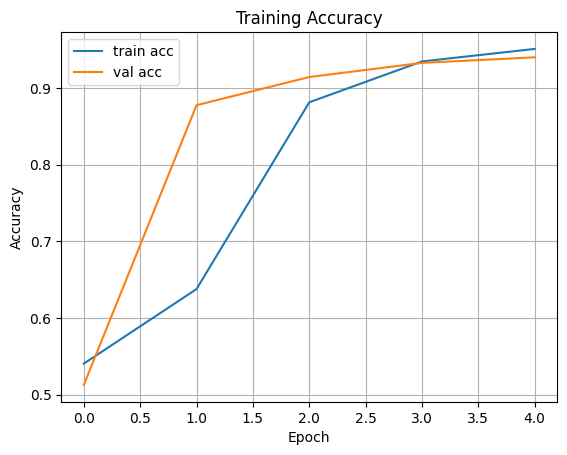

In [ ]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title("Training Accuracy")
plt.grid(True)
plt.show()

1011/1011 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step
253/253 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step


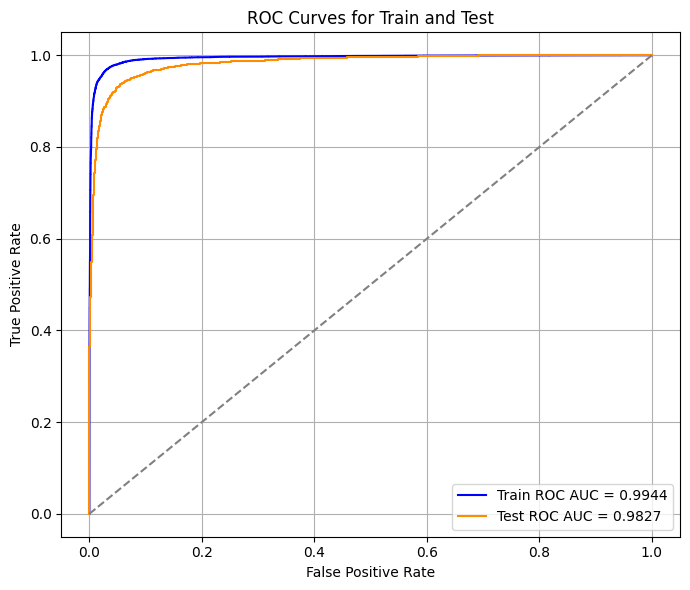

In [ ]:
# Предсказания вероятностей
y_train_prob = model.predict(X_train).ravel()
y_test_prob = model.predict(X_test).ravel()

# ROC-кривая и AUC для трейна
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob)
auc_train = roc_auc_score(y_train, y_train_prob)

# ROC-кривая и AUC для теста
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)
auc_test = roc_auc_score(y_test, y_test_prob)

# Построение графика
plt.figure(figsize=(7, 6))
plt.plot(fpr_train, tpr_train, label=f'Train ROC AUC = {auc_train:.4f}', color='blue')
plt.plot(fpr_test, tpr_test, label=f'Test ROC AUC = {auc_test:.4f}', color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Train and Test')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()



1011/1011 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step
253/253 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step


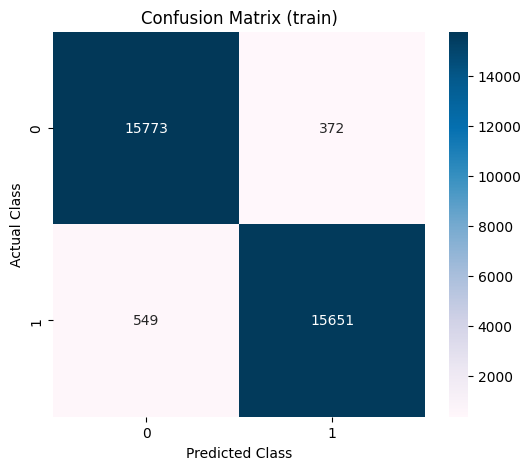

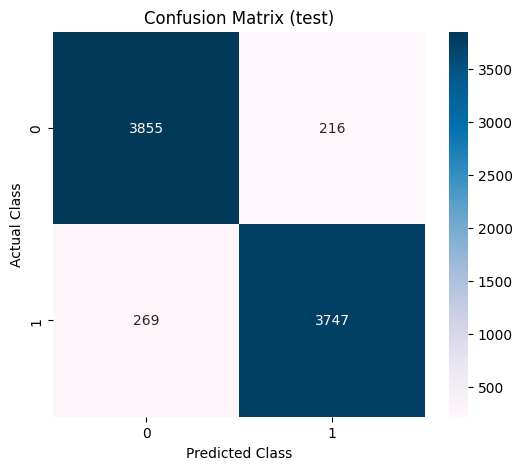

In [ ]:
# Прогноз классов (0 или 1) для трейна и теста
y_train_pred = (model.predict(X_train).ravel() >= 0.5).astype(int)
y_test_pred = (model.predict(X_test).ravel() >= 0.5).astype(int)

# Матрицы ошибок
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

#confusion matrix for train
plt.figure(figsize=(6, 5))
sns.heatmap(cm_train, annot=True, fmt="d", cmap="PuBu")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.title("Confusion Matrix (train)")
plt.show()

plt.figure(figsize=(6, 5))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="PuBu")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.title("Confusion Matrix (test)")
plt.show()

## Keras tuner for LSTM

In [12]:
pip install keras-tuner --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.8 MB/s eta 0:00:00


In [24]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense

def build_model(hp):
    model = Sequential()
    model.add(Embedding(
        input_dim=MAX_VOCAB_SIZE,
        output_dim=128,  # Зафиксировано
        input_length=MAX_SEQUENCE_LENGTH
    ))

    model.add(LSTM(
        units=hp.Choice('lstm_1_units', [64, 128]),
        return_sequences=True
    ))
    model.add(Dropout(hp.Choice('dropout_1', [0.3, 0.5])))

    model.add(LSTM(
        units=hp.Choice('lstm_2_units', [32, 64])
    ))
    model.add(Dropout(hp.Choice('dropout_2', [0.3, 0.5])))

    model.add(Dense(32, activation='relu'))  # Зафиксировано
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

In [25]:
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='my_dir',
    project_name='lstm_tuning'
)

# Callback для ранней остановки
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Запуск тюнера
tuner.search(padded_sequences, labels, epochs=10, validation_split=0.2, callbacks=[stop_early])

# Лучшие параметры
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Лучшие параметры:\n{best_hps.values}")

Trial 22 Complete [00h 00m 42s]
val_accuracy: 0.5185286998748779

Best val_accuracy So Far: 0.9234147667884827
Total elapsed time: 00h 11m 48s
Лучшие параметры:
{'lstm_1_units': 128, 'dropout_1': 0.5, 'lstm_2_units': 64, 'dropout_2': 0.3, 'tuner/epochs': 10, 'tuner/initial_epoch': 4, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0015'}


In [28]:
# prompt: Как теперь сделать красивую табличку с информациями о подборе параметров тут, вывести все эксперименты
# tuner = kt.Hyperband(
#     build_model,
#     objective='val_accuracy',
#     max_epochs=10,
#     factor=3,
#     directory='my_dir',
#     project_name='lstm_tuning'
# )
# # Callback для ранней остановки
# stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
# # Запуск тюнера
# tuner.search(padded_sequences, labels, epochs=10, validation_split=0.2, callbacks=[stop_early])
# # Лучшие параметры
# best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
# print(f"Лучшие параметры:\n{best_hps.values}")

import pandas as pd

# Assuming tuner and best_hps are defined as in your provided code
# ... (your existing code) ...

# Extract the results from the tuner
trials = tuner.oracle.get_best_trials(num_trials=len(tuner.oracle.trials))
results = []

for trial in trials:
    result = trial.hyperparameters.values.copy()
    result['val_accuracy'] = trial.score
    result['trial_id'] = trial.trial_id
    results.append(result)

# Create a Pandas DataFrame
trials_df = pd.DataFrame(results)

# Display the DataFrame as a formatted table
print(trials_df[['trial_id', 'lstm_1_units', 'dropout_1', 'lstm_2_units', 'dropout_2', 'val_accuracy']].sort_values('val_accuracy', ascending=False))
export = trials_df[['trial_id', 'lstm_1_units', 'dropout_1', 'lstm_2_units', 'dropout_2', 'val_accuracy']].sort_values('val_accuracy', ascending=False).to_excel('tuning_lstm.xlsx')

   trial_id  lstm_1_units  dropout_1  lstm_2_units  dropout_2  val_accuracy
0      0016           128        0.5            64        0.3      0.923415
1      0017           128        0.5            32        0.3      0.923415
2      0015           128        0.5            64        0.3      0.895690
3      0020            64        0.5            32        0.5      0.888004
4      0006            64        0.5            32        0.3      0.679385
5      0001           128        0.5            32        0.3      0.639308
6      0010           128        0.3            32        0.5      0.638759
7      0013           128        0.5            32        0.3      0.622289
8      0002           128        0.5            64        0.3      0.609662
9      0014           128        0.3            32        0.5      0.598682
10     0018           128        0.5            64        0.5      0.589624
11     0012            64        0.5            32        0.3      0.557782
12     0007 